# Introduction to Markov Chain Monte Carlo

### Matthew Heffernan

#### McGill Nuclear Theory Journal Club

#### 16 October 2020

This notebook is adapted by Matthew Heffernan from the excellent materials of Dick Furnstahl's Physics 8805 course at The Ohio State University. Some of the examples taken here were adapted the TALENT course on Learning from Data: Bayesian Methods and Machine Learning in York, UK, June 10-28, 2019. The original notebook was by Christian Forssen with adaptations by Dick Furnstahl. Further underlying credit is due to inspiration from ["MCMC sampling for dummies"](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) in the excellent blog ["While my MCMC gently samples"](https://twiecki.io/) by Thomas Wiecki.

### Import Modules

In [2]:
import numpy as np
from scipy.stats import norm, uniform, cauchy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sbn
sbn.set_style('white')
sbn.set_context('talk')

import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# MCMC sampling of a Lorentzian pdf

We can perform a random walk and accept all steps unless they were outside a hard-wall boundary. This corresponds to a situation where all positions within that region is equally probable, and all positions outside have probability zero. 

* What pdf does that situation correspond to?

Now, let us try another situation in which we have some function that tells us the (possibly unnormalized) probability of a given position. We will assume a known, specific form of this pdf, namely a Lorentzian (Cauchy) distribution, but it might just as well be some very complicated function that can only be evaluated numerically. All that is needed is some function that, for each position in the parameter space, returns a probability.

Let us start by studying the pdf that we will be sampling from using a random walk (using the Metropolis algorithm outlined below). 

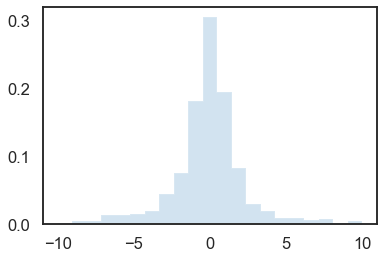

In [6]:
# Draw a number of random samples from the standard Cauchy
r = cauchy.rvs(size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2,
         range=(-10,10),bins=21);

### Questions:
This histogram corresponds to a finite sample from the pdf of a standard Cauchy (Lorentzian)
$$ 
p(x | \alpha=0, \beta=1) = \frac{1}{\pi(1+x^2)}, 
$$
with mean $\alpha=0$ and FWHM $2\beta = 2$.

- How does this pdf compare with a standard normal distribution $\mathcal{N}(x;\mu=0,\sigma^2=1)$?
- What is the function of the optional argument 'density=True' in the 'hist' plot function call in the cell above?
- What happens if you remove the optional 'range' and 'bins' arguments from the 'hist' plot function call in the cell above?
- Why? How would this look when plotting a histogram for random samples from a standard normal distribution? 

Let us turn the posterior into a callable function. We will deliberately remove the normalization to make the point that sampling can be made for an unnormalized pdf:

In [7]:
def posterior_function(x):
    return 1 / (1+x**2)

def normalized_posterior_function(x):
    return 1 / (np.pi * (1+x**2))

## The Metropolis-Hastings Algorithm

Here, we present the algorithm first presented in [this paper (yes, it's that Edward Teller)](https://bayes.wustl.edu/Manual/EquationOfState.pdf) with a nice clarification provided [here](https://stats.stackexchange.com/questions/448692/proof-of-convergence-in-original-metropolis-algorithm-paper).

Now on to the sampling. At first, you define the starting parameter position (can be randomly chosen), let's fix it arbitrarily to:

```python
current_position = 1.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a proposal distribution (here we again choose a normal distribution) centered around your current position (i.e. `current_position`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're using `scipy.stats.norm`):

```python
proposal_position = norm(current_position, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. We quantify this by computing the probability of the proposed position in parameter space, i.e. evaluating the posterior pdf at the proposed position. Usually you would use log probabilities but we omit this here.

```python
# Nominator of Bayes' formula
p_current = posterior(current_position)
p_proposal = posterior(proposed_position)

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `proposed_position` has higher likelihood than `current_position`. Eventually we'll get to `x = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior pdf so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. Note that the acceptance probability is obtained by dividing the posterior of proposed parameter setting by the posterior of the current parameter setting. This implies that the posterior pdf does not necessarily need to be normalized, the normalization factor will anyway be canceled out. 

You can see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there which we will decide by drawing a random number:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    current_position = proposed_position

```

This simple procedure gives us samples from the posterior.

## Let's put it another way

Above, we described the ["Metropolis-Hastings algorithm"](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) for sampling as follows:
1. Choose an initial position $x$ (call it $x_0$ and subsequently $x_i$)
2. Sample a proposal distribution to find a new position $x'$.
3. Compute the Metropolis ratio $r = p(x')\, /\, p(x_i)$. 
4. Given another uniform random number $y \sim U(0,1)$, $x_{i+1} = x'$ if $y \leq r$, else $x_{i+1} = x_i$ (i.e., keep the same value for the next $x$).
5. Repeat 2.-4. until you think you have enough samples of $x$.
6. When graphing the posterior or calculating averages, skip the first values until the sampling has equilibrated (this is generally called the "burn-in" or "warm-up").


## Now let's perform some sampling and visualize it

In [10]:
def sampler(posterior_func, no_of_samples=4, start_position=.5, 
            proposal_width=1., plot=False):
    current_position = start_position
    samples = [current_position]
    for i in range(no_of_samples):
        # suggest new position
        proposed_position = norm(current_position, proposal_width).rvs()

        # Compute posteriors of current and proposed position       
        p_current = posterior_func(current_position)
        p_proposal = posterior_func(proposed_position) 
        
        # Acceptance probability
        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        p_accept = p_proposal / p_current
        
        # Accept proposal?
        accept = np.random.rand() < p_accept
        
        # Visualization
        if plot:
            assert no_of_samples < 21, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accept, samples, i)
        
        if accept:
            # Update position
            current_position = proposed_position
        
        samples.append(current_position)
        
    return np.array(samples)

# Function to display
def plot_proposal(posterior_func, current_position, p_current, 
                  proposed_position, p_proposal, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-5, 5, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot posterior
    ax1.plot(x, posterior_func(x))
    ax1.plot([current_position] * 2, [0, p_current], marker='o', color='b')
    ax1.plot([proposed_position] * 2, [0, p_proposal], marker='o', color=color)
    ax1.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', \
            title='current: posterior(mu=%.2f) = %.2f\nproposal: posterior(mu=%.2f) = %.2f' \
            % (current_position, p_current, proposed_position, p_proposal))
    
    if accepted:
        trace.append(proposed_position)
    else:
        trace.append(current_position)
        
    # Posterior histogram
    ax2.plot(x, normalized_posterior_function(x)) # properly normalized
    sbn.distplot(trace, kde=False, norm_hist=True, ax=ax2)
    ax2.axvline(current_position, color='b', linestyle='--', 
                label='current position')
    ax2.axvline(proposed_position, color=color, linestyle='--', 
                label='proposed position')
    ax2.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))

    
    ax3.plot(trace)
    ax3.set(xlabel='iteration', ylabel='position', title='trace')
    plt.tight_layout()

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first column displays our unnormalized posterior distribution. This is for visualization only, normally we would not be able to plot a nice curve to show the posterior. Here, we plug in our $x$ proposals. The vertical lines represent our current position in blue and our proposed position in either red or green (rejected or accepted, respectively). 

The second column is our posterior distribution. Here we are displaying the normalized posterior as the blue curve compared to the normalized histogram of samples (green bars) and the move that was just proposed.

The third column is our trace (i.e. the posterior samples of visited positions that we're generating). Note that we store a sample at each iteration, irrespective of whether the propsal was accepted or rejected. In the latter situation, we keep the previous position and the line just stays constant.

Note that we always accept moves to relatively more likely $x$ values (in terms of their posterior density), but only sometimes to relatively less likely $x$ values, as can be seen already in the first iteration, and later in iterations 6, 7, and 8 (the iteration number can be found at the top center of each row).

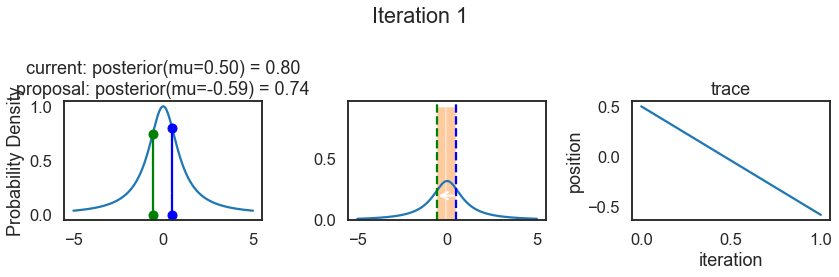

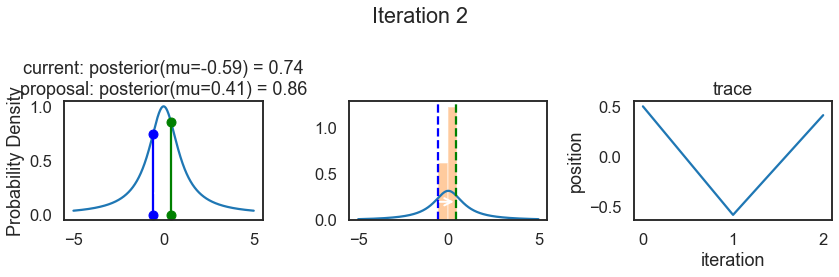

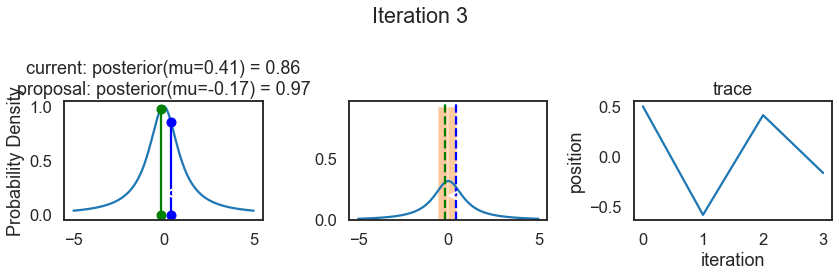

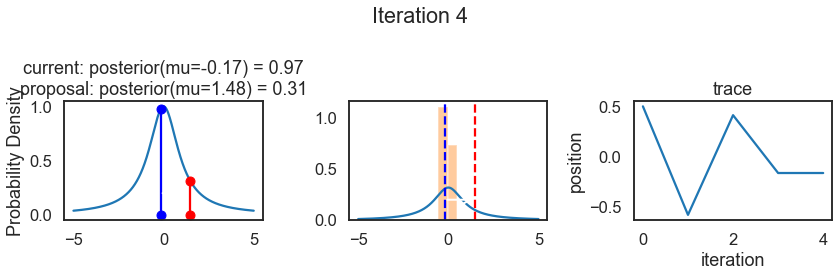

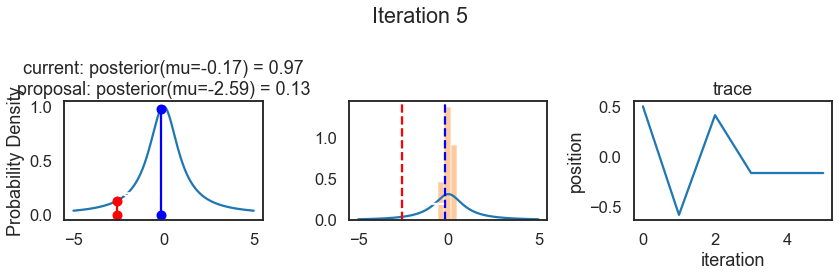

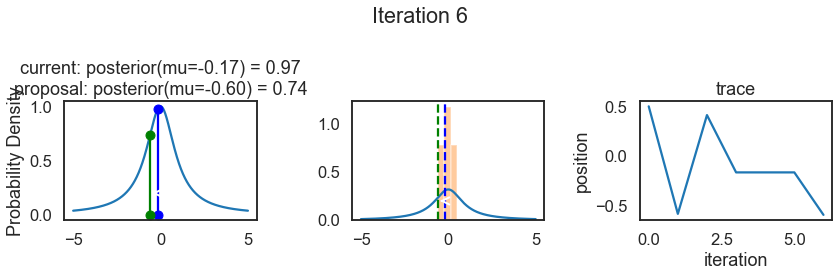

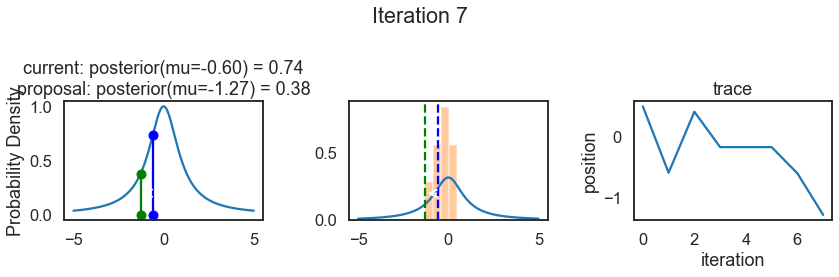

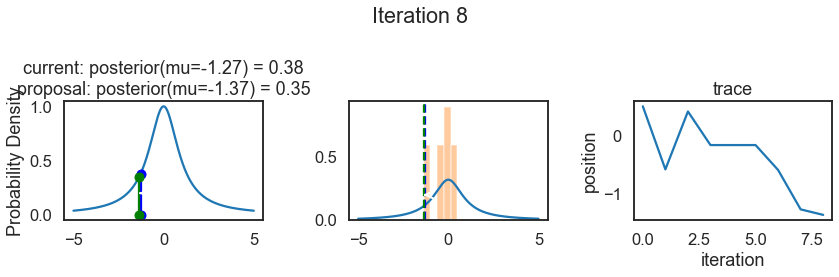

In [11]:
np.random.seed(123)
samples = sampler(posterior_function, no_of_samples=8, start_position=.5, proposal_width=1., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this, which we won't go into detail here.

To get a sense of what this produces, lets draw a lot of samples and plot them.

In [12]:
samples = sampler(posterior_function, no_of_samples=5000, start_position=1.,proposal_width=1)

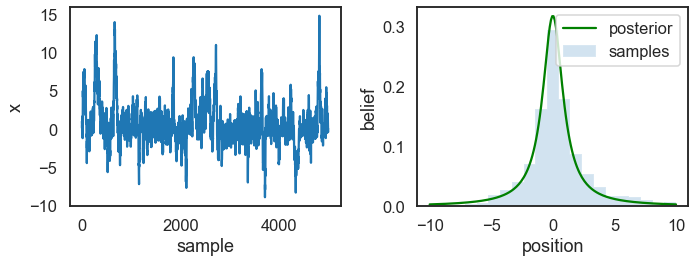

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(samples)
ax1.set(xlabel='sample', ylabel='x');

ax2.hist(samples[500:], density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10), bins=21, label='samples')
x = np.linspace(-10., 10., 200)
ax2.plot(x, normalized_posterior_function(x), 'g', label='posterior')
ax2.set(xlabel='position', ylabel='belief');
ax2.legend();
plt.tight_layout()

The plot in the left panel is usually called the trace. To get an approximation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. That histogram is shown in the right panel which then represents our **belief** in the probability density for different `positions`. For comparison we also show (green line) the properly normalized posterior pdf, for which we had a known analytical form in this case.

### Questions

1. You can try increasing or decreasing the number of samples.
2. What happens if you try with another proposal distribution, e.g. a uniform one?
3. What happens if you decrease the width of the proposal distribution?

When answering the last question you probably did find that the proposal changed quite drastically when using the same number of samples, but taking much shorter steps. This is a consequence of the collected samples being *correlated*. 

We can define the autocorrelation function $\rho(h)$ from the list of samples $X$, where $X_t$ is sample $t$ and $X_{t+h}$ is a shifted version of $X_t$ with $h$ being called the *lag*
$$
\rho(h) = \frac{\sum_\mathrm{overlap} \left[ (X_t - \bar{X}) (X_{t+h} - \bar{X})\right]}
{\sqrt{ \sum_\mathrm{overlap} (X_t - \bar{X})^2 } \sqrt{ \sum_\mathrm{overlap} (X_{t+h} - \bar{X})^2 }}
$$
The summation is carried out over the subset of samples that overlap.

In [15]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

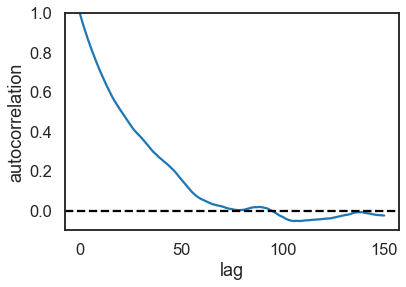

In [24]:
acors = autocorrelation(samples,max_lag=150)
fig, ax = plt.subplots()
ax.plot(acors);
plt.axhline(y=0, color="black", linestyle="--")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1.));

### Questions / tasks
* Add functionality to extract the acceptance rate (i.e. the fraction of proposed steps that are accepted).
* Print the acceptance rate and plot the autocorrelation function / autocorrelation time when performing the following studies:
* Based mainly on empirical studies, Roberts, Gelman, and Gilks (1997) recommend calibrating the acceptance rate to about 25% for a high-dimensional model, and to about 50% for models of one or two dimensions. How can you calibrate the acceptance rate of your MCMC sampler?
* Try to sample from some other posterior pdf.
* What happens when you change the proposal distribution: 
    * Using a different proposal distribution?
    * What happens if you make it asymmetric around the 'current_position'?
    * What happens if you stick to the normal distribution as a proposal distribution, but change its width?
* How would you define that a MCMC algorithm works? What is the property that you are after?
* The Metropolis algorithm works because it has three properties:
    * It is _irreducible_
    * It is _aperiodic_
    * It is _positive recurrent_
    
  What do you think that these properties mean?

In [25]:
# Sample functionality to extract the acceptance rate, but play with your own version to make this more efficient
def acceptance(samps):
    unique_vals = set(samps)
    acceptance_fraction = len(unique_vals)/len(samps)
    #print("Acceptance fraction: %1.3f" % (acceptance_fraction))
    return acceptance_fraction
    
def find_tau(autocorr):
    tau = []
    for h in range(len(autocorr)):
        #rho = np.exp(-h/tau)
        tau.append(-h/np.log(autocorr[h]))
    return tau

In [30]:
# Calibrate the proposal width using the acceptance fraction and plot the autocorrelation function

prop_width = 1
samples = sampler(posterior_function, no_of_samples=5000, start_position=1., proposal_width=prop_width)
accept = acceptance(samples)

# Calibrating the proposal width using the acceptance fraction
while accept > 0.7:
    prop_width += 0.5
    samples = sampler(posterior_function, no_of_samples=1500, start_position=1., proposal_width=prop_width)
    accept = acceptance(samples)
    print('Acceptance fraction  %1.3f' % (accept))
    
while accept > 0.55:
    prop_width += 0.2
    samples = sampler(posterior_function, no_of_samples=5000, start_position=1., proposal_width=prop_width)
    accept = acceptance(samples)
    print('Acceptance fraction  %1.3f' % (accept))  
    
while accept > 0.5:
    prop_width += 0.1
    samples = sampler(posterior_function, no_of_samples=10000, start_position=1., proposal_width=prop_width)
    accept = acceptance(samples)
    print('Acceptance fraction  %1.3f' % (accept))  

print('Calibrated proposal width: ',prop_width)


Acceptance fraction  0.699
Acceptance fraction  0.693
Acceptance fraction  0.645
Acceptance fraction  0.627
Acceptance fraction  0.570
Acceptance fraction  0.568
Acceptance fraction  0.559
Acceptance fraction  0.536
Acceptance fraction  0.506
Acceptance fraction  0.513
Acceptance fraction  0.540
Acceptance fraction  0.494
Calibrated proposal width:  3.300000000000001


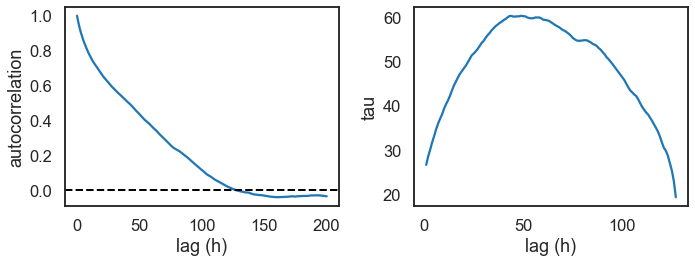

In [43]:
acors = autocorrelation(samples,max_lag=200)
taus = find_tau(acors)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.plot(acors);
ax1.axhline(0, color='black', linestyle = '--', lw=2)
ax1.set(xlabel='lag (h)', ylabel='autocorrelation');

ax2.plot(taus);
ax2.set(xlabel='lag (h)', ylabel='tau');

plt.tight_layout()

We can see that the relaxation time for the autocorrelation tau is a reasonable enough description at early times and then becomes unstable as the autocorrelation function fluctuates around 0. The properties of this will change as the underlying distributions are modified.

# Diagnostics

How do we know our MCMC chain has converged? Here, we quickly explore some means of assessing convergence. We will also use a more sophisticated MCMC package, but we'll use it in Metropolis-Hastings mode. Using a pre-built MCMC sampling package will make it easier to show the diagnostics.

To show the diagnostics, we will use the model that we developed in the Intro-to-Bayes noteboook form my last talk.

### Recap: Gaussian Noise and Averages

Let us consider the problem of estimating the mean and the variance of a normal distribution that is associated with a collection of random variables. The normal distribution
$$
p(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right),
$$
is often used as a theoretical model to describe the noise associated with experimental data.

Let us assume that we have a series of $M$ measurements $D \equiv \{ x_k \} = (x_1, \ldots, x_M)$, that are samples from a normal $N(\mu, \sigma^2)$ population, from which we would like to learn the approximate values of the parameters $\mu$ and $\sigma$. The standard frequentist approach to this problem is the maximum likelihood method. The Bayesian approach is to compute the posterior distribution for the model parameters $\mu$ and $\sigma$.

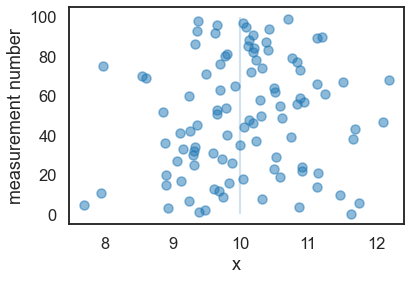

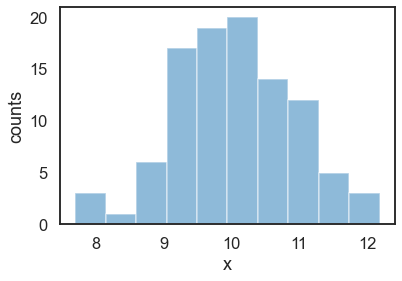

In [78]:
# Generating some data
np.random.seed(1)  # for repeatability we specify the seed

mu_true = 10.   # true peak position
sigma_true = 1. # true standard deviation
M = 100         # number of measurements
D = norm.rvs(mu_true, sigma_true, size=M)  # M measurements (samples)

fig1, ax1 = plt.subplots()
ax1.scatter(D, np.arange(M), alpha=0.5)
ax1.vlines([mu_true], 0, M, alpha=0.2)
ax1.set_xlabel("x");ax1.set_ylabel("measurement number");

fig2, ax2 = plt.subplots()
ax2.hist(D,alpha=0.5)
#ax1.vlines([mu_true], 0, M, alpha=0.2)
ax2.set_xlabel("x");ax2.set_ylabel("counts");

To perform this MCMC, we start by defining Python functions for the prior $p(\mu,\sigma~|~I)$, the likelihood $p(D~|~\mu,\sigma, I)$, and the posterior $p(\mu,\sigma~|~D,I)$, noting that none of these need be properly normalized. Our model here is two-dimensional so we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [\mu,\sigma]$:

In [79]:
min_theta=np.array([0,0])
max_theta=np.array([100,10])
volume_theta=np.prod(max_theta - min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    assert len(theta)==2, "Parameter vector must have length two."
    # flat prior 
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1/volume_theta)
    else:
        return -np.inf

def log_likelihood(theta, X):
    '''Log likelihood for data X given parameter array theta'''
    try:
        return -0.5 * np.sum( ( (X - theta[0]) / theta[1] )** 2 ) \
               - 0.5*len(X)*np.log(2*np.pi*theta[1]**2)
    except ValueError:
        return -np.inf

def log_posterior(theta, X):
    '''Log posterior for data X given parameter array theta'''
    return log_prior(theta) + log_likelihood(theta, X)

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [44]:
import emcee
import corner
print('emcee sampling (version: )', emcee.__version__)

emcee sampling (version: ) 3.0.2


In [80]:
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# we'll start at random locations within the prior volume
starting_guesses = min_theta + max_theta * np.random.rand(nwalkers,ndim)

print(f"MCMC sampling using emcee (an affine-invariant ensamble sampler)",
      f"with {nwalkers} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])

# "burn-in" period; save final positions and then reset
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()

# sampling period
sampler.run_mcmc(pos, nsteps)

mean_acc_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*nsteps} steps)")

# Discard burn-in points and flatten the walkers; 
#  the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

MCMC sampling using emcee (an affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.711 (in total 50000 steps)


If this all worked correctly, the array *samples* should contain a series of draws from the posterior. Let's plot them using a so called corner plot (to be discussed in much more detail during the course).

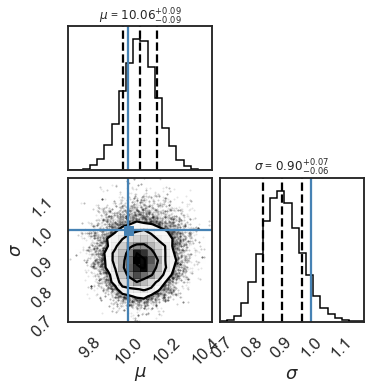

In [81]:
# Make a corner plot with the posterior distribution
fig = corner.corner(samples, labels=["$\mu$", "$\sigma$"],
                    truths=[mu_true, sigma_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

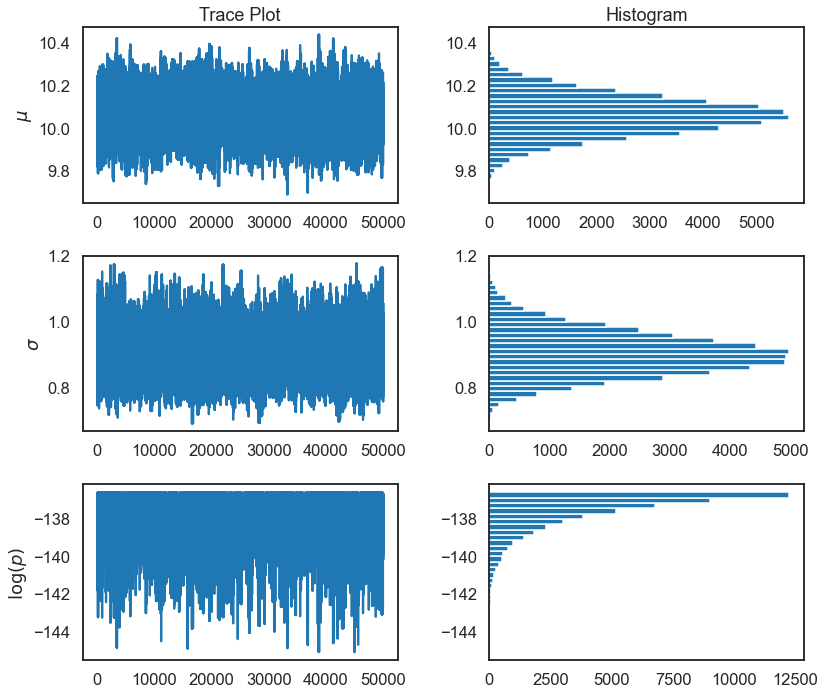

In [88]:
samples = sampler.get_chain(flat=True)
samples_unflattened = sampler.get_chain(flat=False)
lnposts = sampler.get_log_prob(flat=True)

thetas = [r"$\mu$", r"$\sigma$"]

fix, ax = plt.subplots(3,2,figsize=(12,5*ndim))
for irow in range(ndim):
    ax[irow,0].plot(np.arange(samples.shape[0]),samples[:,irow])
    ax[irow,0].set_ylabel(thetas[irow])
    ax[irow,1].hist(samples[:,irow],orientation='horizontal',bins=30)
    
ax[2,0].plot(np.arange(samples.shape[0]),lnposts)
ax[2,1].hist(lnposts,orientation='horizontal',bins=30)
ax[2,0].set_ylabel(r'$\log(p)$')

ax[0,1].set_title('Histogram')
ax[0,0].set_title('Trace Plot')

plt.tight_layout()

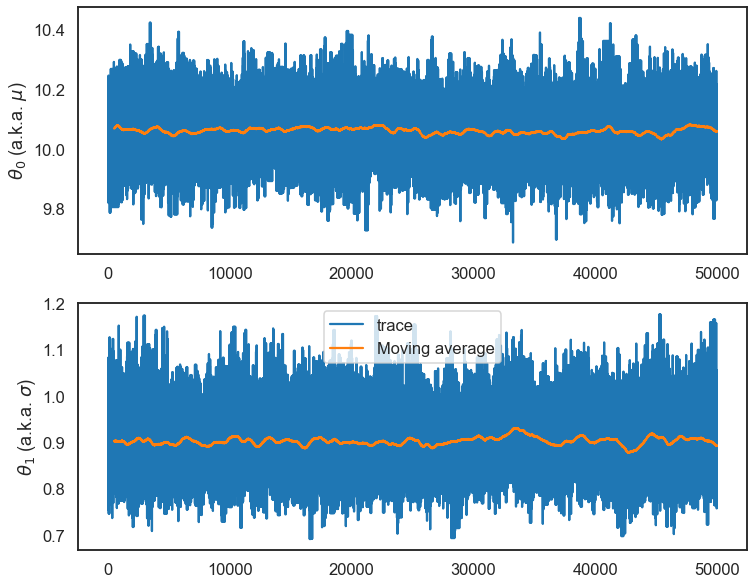

In [93]:
fix, ax = plt.subplots(2,1,figsize=(12,10))
# pandas makes this easy:
df_chain = pd.DataFrame(samples,columns=['theta0','theta1'])
df_chain['ma_theta0'] = df_chain.theta0.rolling(window=500,center=False).mean()
df_chain['ma_theta1'] = df_chain.theta1.rolling(window=500,center=False).mean()

ax[0].plot(np.arange(samples.shape[0]),samples[:,0],label=r'$\theta_0$')
ax[0].plot(np.arange(samples.shape[0]),df_chain['ma_theta0'],label=r'Moving average')
ax[0].set_ylabel(r'$\theta_0$ (a.k.a. $\mu$)')

ax[1].plot(np.arange(samples.shape[0]),samples[:,1],label=r'trace')
ax[1].plot(np.arange(samples.shape[0]),df_chain['ma_theta1'],label=r'Moving average')
ax[1].set_ylabel(r'$\theta_1$ (a.k.a. $\sigma$)')

plt.legend();

### Standard Error of the Mean

This investigates the question how does the **mean** of $\theta$ deviate in our chain, and is capturing the *simulation error* of the mean rather than underlying uncertainty of our parameter $\theta$:

$$
SE({\bar{\theta}}) = \frac{\text{Posterior Standard Deviation}}{\sqrt{N}}
$$

where $N$ is the chain length (the number of iterations in your chain). 

For our problem this is:

In [91]:
for irow in range(ndim):
    print(f"Standard Error of the Mean for theta_{irow}: {samples[:,irow].std()/np.sqrt(samples.shape[0]):.1e}")

Standard Error of the Mean for theta_0: 4.1e-04
Standard Error of the Mean for theta_1: 2.9e-04


This is saying that very little of our posterior variation in $\theta$ is due to sampling error (that is good).  We can visualize this by examining the moving average of our chain as we move through the iterations:

### Autocorrelation plots

In [94]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

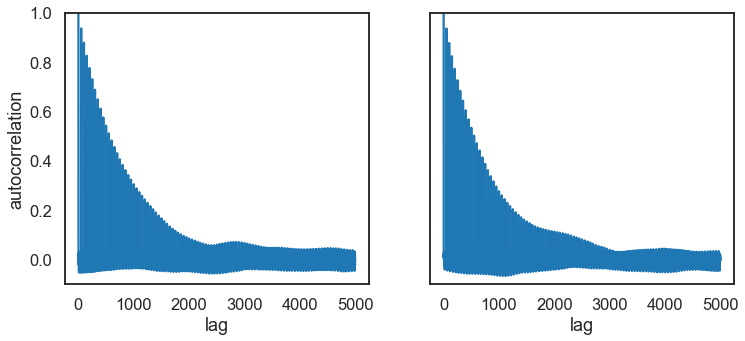

In [101]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(12,5))
for icol in range(ndim):
    acors = autocorrelation(samples[:,icol],max_lag=5000)
    ax[icol].plot(acors)
    ax[icol].set_xlabel('lag')
ax[0].set(ylabel='autocorrelation', ylim=(-.1, 1));

### Acceptance Rate for the MH Algorithm

Recall that we want the acceptance rate to be in the range .5 for a one-to-two parameter model. 

Since the number of **new** members in the chain represent the number of acceptances, count changes in chain values and divide by total chain length to calculate acceptance rate:

In [103]:
print("Acceptance Rate is:", sampler.acceptance_fraction)

Acceptance Rate is: [0.698 0.703 0.719 0.704 0.681 0.716 0.734 0.701 0.721 0.701 0.717 0.701
 0.705 0.716 0.712 0.674 0.726 0.722 0.706 0.714 0.682 0.741 0.737 0.737
 0.692 0.704 0.723 0.732 0.686 0.744 0.682 0.722 0.717 0.7   0.703 0.688
 0.735 0.706 0.722 0.722 0.736 0.708 0.696 0.718 0.697 0.681 0.746 0.69
 0.702 0.713]


We see that our acceptance fractions are a little high, so maybe we should tune our MCMC a bit to better probe the underlying distribution. Remember our corner plot shows that our parameter estimation does not quite recover the true values, although they are in our confidence region.

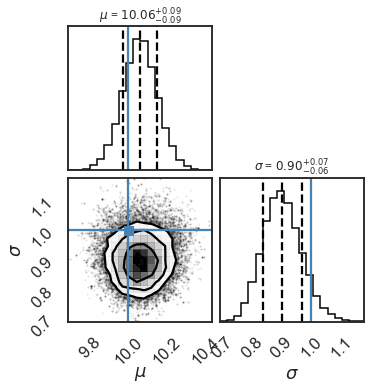

In [105]:
# Plotting again here for illustrative purposes
fig = corner.corner(samples, labels=["$\mu$", "$\sigma$"],
                    truths=[mu_true, sigma_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

### Note on diagnostics

There are many other diagnostics, some of which are quite useful for assessing if you have poorly sampled a multimodal distribution (of which the Gelman-Rubin diagnostic is a good example). Of course, due to time constraints, we are likely to not finish the material here, but the above will likely achieve our goal of providing an introduction to MCMC sampling for the curious.